# The openclean Open-Source Data Cleaning Library

Data preparation is still a major bottleneck for many data science projects. A [frequently cited survey in 2016](https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says) found that data scientists spend 60% of their time on data cleaning and organizing data. In the same survey, 57% of the data scientists also stated that they consider data cleaning and organizing data as the least enjoyable task of their job.

Over the years, many tools for profiling, preparing, and cleaning data have been developed, both in academia and industry (see \[1, 2\] for overviews). These approaches were developed in isolation and in different programming languages with no standardized interfaces. Thus, it is difficult for data scientists to combine existing tools and re-use them in their data processing pipelines.

Inspired by the wide adoption of generic machine learning frameworks such as [scikit-learn](https://scikit-learn.org/stable/), [TensorFlow](https://www.tensorflow.org/), and [PyTorch](https://pytorch.org/), we are currently developing **openclean**, an open-source Python library for data profiling and data cleaning. The source code for **openclean** is [available on GitHub](https://github.com/VIDA-NYU/openclean).

Our goals for **openclean** are twofold. First, we aim to provide a unified framework for practitioners that brings together open-source data profiling and data cleaning tools into an easy-to-use environment.  By making existing tools available to a large user-community, and through the integration with the rich Python ecosystem, **openclean** has the potential to simplify data cleaning tasks. Second, by  providing a structured, extensible framework, **openclean** can serve as a platform to which researchers and developers can contribute their techniques.  We hope that by bringing together a community of users, developers, and researchers, we will be in a better position to attack the many challenges in dealing with data quality.

**openclean** has many features that make the data wrangling experience straightforward. It shines particularly in these areas:

- *Data Profiling*: **openclean** comes with a profiler to provide users actionable metrics about data quality. It allows users to detect possible problems early on by providing various statistical measures of the data from min-max frequencies, to uniqueness and entropy calculations.
- *Data Cleaning & Wrangling*: **openclean**'s operators have been created specifically to handle data janitorial tasks. They help identify and present statistical anomalies, fix functional dependency violations, locate and update spelling mistakes, and handle missing values gracefully.
- *Data Enrichment*: **openclean** seamlessly integrates with the Socrata Open Data API and the Reference Data Repository giving users easy access to standard datasets which can be incorporated in the data cleaning process.
- *Data Provenance*: **openclean** comes with a mini-version control engine that allows users to maintain versions of their datasets and at any point commit, checkout or rollback changes.


# NYC Parking Violations - Data Profiling and Data Cleaning Examples

In the following we give an overview of the basic operators and concepts in openclean using a running example (see the [README file](https://github.com/VIDA-NYU/openclean/blob/master/README.rst) for installation instructions).

The dataset that is used for all the examples is the [NYC Parking Violations Issued - Fiscal Year 2014](https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2014/jt7v-77mi), which contains violations issued during the 2014 fiscal year. This dataset contains  several data quality problems and is a great example for demonstrating data profiling and data cleaning steps. The dataset consists of over 9 million rows and the compressed data file is about 380 MB in size (~1.7 GB uncompressed).

## Datasets and Streams

The dataset is available for download via the [Socrata Open Data API (SODA)](https://dev.socrata.com/). To download the dataset, **openclean** includes a SODA wrapper that provides access to all datasets available via the API using their unique identifier. The parking violations dataset, for example, has the unique identifier `jt7v-77mi`. The identifier is part of the dataste Url https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2014/jt7v-77mi. The following code downloads the dataset in tab-delimited CSV format and stores it in a local file called `jt7v-77mi.tsv.gz`.

In [1]:
# Download the full 'NYC Parking Violations Issued - Fiscal Year 2014' dataset.
# Note that the downloaded full dataset file is about 380 MB in size! Use the
# alternative data file with 10,000 rows that is included in the repository if
# you do not want to download the full data file.

import gzip
import humanfriendly
import os

from openclean.data.source.socrata import Socrata

dataset = Socrata().dataset('jt7v-77mi')

# By default, this example uses a small sample of the full dataset that
# is included in the 'data' subfolder within this repository.
#datafile = './data/jt7v-77mi.tsv.gz'

# Remove the comment for this line if you want to use the full dataset.
datafile = './jt7v-77mi.tsv.gz'


# Download file only if it does not exist already.
if not os.path.isfile(datafile):
    with gzip.open(datafile, 'wb') as f:
        print('Downloading ...\n')
        dataset.write(f)


fsize = humanfriendly.format_size(os.stat(datafile).st_size)
print("Using '{}' in file {} of size {}".format(dataset.name, datafile, fsize))

Using 'Parking Violations Issued - Fiscal Year 2014' in file ./jt7v-77mi.tsv.gz of size 379.19 MB


**openclean** is primarily intended for tabular datasets, which are represented as [pandas data frames](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). After downloading the dataset file, we can, for example, open it as a data frame using the `pandas.read_csv()` function. This requires reading the full dataset into main memory. For large datasets this may not be feasible, and in some cases we don’t need all the data. For these scenarios, **openclean**’s data streaming operator allows us to apply data profiling, filtering, and transformation operations directly on a stream of rows that are read from the file. As an example, the created data stream has a `head()` operator that by default will return the first ten rows from the dataset file as a pandas.DataFrame.

In [2]:
# Due to the size of the full dataset file, we make use of openclean's
# stream operator to avoid having to load the dataset into main-memory.

from openclean.pipeline import stream

ds = stream(datafile)

In [3]:
# Print the first ten rows of the dataset to get a first
# idea of the content.

ds.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
0,1361929741,FCJ5493,NY,PAS,12/18/1970,20,SUBN,GMC,S,35030,...,BLACK,0,2013,-,0,,,,,
1,1366962000,63540MC,NY,COM,02/02/1971,46,DELV,FRUEH,P,58830,...,BRN,0,2013,-,0,,,,,
2,1342296187,GCY4187,NY,SRF,09/18/1971,21,VAN,FORD,S,11790,...,BLUE,0,2002,-,0,,,,,
3,1342296199,95V6675,TX,PAS,09/18/1971,21,,GMC,S,11790,...,SILVR,0,2008,-,0,,,,,
4,1342296217,FYM5117,NY,SRF,09/18/1971,21,SUBN,NISSA,S,28190,...,WHITE,0,2012,-,0,,,,,
5,1356906515,GFM1421,NY,PAS,09/18/1971,40,SDN,MAZDA,X,13610,...,BLK,0,2010,-,7,,,,,
6,1337077380,18972BB,NY,999,10/10/1971,14,BUS,INTER,P,8440,...,YELLO,0,2001,-,0,,,,,
7,1364523796,WNJ4730,VA,PAS,04/05/1973,14,SDN,TOYOT,P,50830,...,BLK,0,0,-,0,,,,,
8,1359914924,68091JZ,NY,COM,07/22/1973,46,DELV,TOYOT,P,10610,...,WH,0,2010,-,0,,,,,
9,1355498326,EWV4127,NY,PAS,08/12/1973,21,SUBN,ACURA,X,42630,...,GREY,0,2005,-,0,,,,,


## Data Profiling

Data profiling is an important first step in many data analytics efforts. Profiling helps users to gain an understanding of the data properties and to uncover data quality flaws. **openclean** supports a variety of different data profiling operators that can also be used to generate metadata about the data at hand.

We can use the default column profiler to compute basic statistics such as the number of distinct values, missing values, etc. for each of the columns in our dataset. In the example shown below we use a random sample of 1000 rows for profiling. The result is a list of profiling results (dictionaries). A summary of the results can then be accessed as a data frame using the `stats()` method.

In [4]:
# Profile a sample of 1000 rows using the default data profiler.

from openclean.profiling.column import DefaultColumnProfiler

profiles = ds\
    .sample(n=1000, random_state=42)\
    .profile(default_profiler=DefaultColumnProfiler)

In [5]:
# Print overview of profiling results.

profiles.stats()

,total,empty,distinct,uniqueness,entropy
Summons Number,1000,0,1000,1.000000,9.965784
Plate ID,1000,0,997,0.997000,9.959784
Registration State,1000,0,36,0.036000,1.559809
Plate Type,1000,0,18,0.018000,1.312779
Issue Date,1000,0,306,0.306000,8.045415
Violation Code,1000,0,52,0.052000,4.366667
Vehicle Body Type,1000,7,27,0.027190,2.806224
Vehicle Make,1000,9,59,0.059536,4.660736
Issuing Agency,1000,0,5,0.005000,1.065302
Street Code1,1000,0,531,0.531000,8.125434


In [6]:
# Print dataset columns that contain non-empty values together with the most
# frequent data type from the profiling results.

print('Schema\n------')
for col in ds.columns:
    p = profiles.column(col)
    if p['emptyValueCount'] == 1000:
        continue
    print("  '{}' ({})".format(col, p['datatypes']['distinct'].most_common(1)[0][0]))
    
# Print number of rows.
    
print('\n{:,} rows.'.format(ds.count()))

Schema
------
  'Summons Number' (int)
  'Plate ID' (str)
  'Registration State' (str)
  'Plate Type' (str)
  'Issue Date' (date)
  'Violation Code' (int)
  'Vehicle Body Type' (str)
  'Vehicle Make' (str)
  'Issuing Agency' (str)
  'Street Code1' (int)
  'Street Code2' (int)
  'Street Code3' (int)
  'Vehicle Expiration Date' (int)
  'Violation Location' (int)
  'Violation Precinct' (int)
  'Issuer Precinct' (int)
  'Issuer Code' (int)
  'Issuer Command' (int)
  'Issuer Squad' (str)
  'Violation Time' (str)
  'Time First Observed' (str)
  'Violation County' (str)
  'Violation In Front Of Or Opposite' (str)
  'Number' (int)
  'Street' (str)
  'Intersecting Street' (str)
  'Date First Observed' (int)
  'Law Section' (int)
  'Sub Division' (str)
  'Violation Legal Code' (str)
  'Days Parking In Effect    ' (str)
  'From Hours In Effect' (str)
  'To Hours In Effect' (str)
  'Vehicle Color' (str)
  'Unregistered Vehicle?' (int)
  'Vehicle Year' (int)
  'Meter Number' (str)
  'Feet From Curb

**openclean** is designed to be extensible, to make it easy to add new functionality, and to customize data profiling and cleaning operators. In the previous example, we could use any profiler that implements the [openclean.profiling.base.DataProfiler](https://github.com/VIDA-NYU/openclean-core/blob/master/openclean/profiling/base.py) class instead of the default profiler. One example is the [datamart-profiler](https://pypi.org/project/datamart-profiler/) (used by the [notebook extension of openclean](https://github.com/VIDA-NYU/openclean-notebook)) that provides a richer set of metadata and more powerful data type detection compared to the default column profiler (see discussion in GUI - Integration with Jupyter Notebooks).


## Outliers and Anomalies in Dataset Columns

One common profiling task is the detection of outliers (anomalies) in datasets. In our example we focus on outlier values in individual columns. This example looks at the distinct values in the column Registration State. It shows that the column contains a total of 69 values, which is more than the 50 U.S. states and even two more than in the [list of state codes that is published by the NYC Department of Finance](http://www.nyc.gov/html/dof/html/pdf/faq/stars_codes.pdf).

### Registration State

This example looks at the distinct values in the column *Registration State*. It shows that the column contains a total of 69 values, which is more than the 50 U.S. states and even two more than in the [list of state codes that is published by the NYC Department of Finance](http://www.nyc.gov/html/dof/html/pdf/faq/stars_codes.pdf).

In [7]:
# Get set of distinct values for column 'Registration State'. Print the
# values in decreasing order of frequency.

states = ds.distinct('Registration State')
for rank, val in enumerate(states.most_common()):
    st, freq = val
    print('{:<3} {}  {:>10}'.format('{}.'.format(rank + 1), st, '{:,}'.format(freq)))

1.  NY   7,029,804
2.  NJ     878,677
3.  PA     225,760
4.  CT     136,973
5.  FL     111,887
6.  MA      78,650
7.  VA      60,951
8.  MD      50,407
9.  IN      49,126
10. NC      47,117
11. 99      38,080
12. IL      31,763
13. GA      30,837
14. AZ      24,245
15. TX      24,092
16. OH      21,995
17. CA      20,100
18. OK      19,688
19. SC      19,529
20. ME      19,459
21. TN      18,396
22. MI      16,365
23. DE      14,643
24. RI      13,296
25. MN      12,901
26. NH       9,930
27. VT       7,215
28. IA       7,166
29. WA       5,967
30. ID       5,863
31. AL       5,828
32. QB       5,336
33. WI       5,311
34. DP       5,264
35. ON       5,183
36. DC       3,728
37. CO       3,663
38. OR       3,484
39. MS       3,428
40. KY       3,222
41. NM       2,936
42. MO       2,876
43. AR       2,716
44. LA       2,500
45. NV       2,131
46. WV       1,688
47. NE       1,626
48. GV       1,317
49. KS       1,226
50. AK         961
51. UT         942
52. SD         691
53. MT      

One solution to identify the invalid values is to use a curated list of license plate state codes. Reference data is an important tool for data cleaning and **openclean** supports the use of different reference datasets. For this purpose, we created the open-source library [refdata](https://github.com/VIDA-NYU/reference-data-repository) to provide access to reference datasets available on the Web. Individual datasets are hosted by data maintainers on the platform of their choice. Users can download copies of the datasets for local access.

In [8]:
# List identifier and names for available reference datasets.

from openclean.data.refdata import RefStore

refdata = RefStore()
for entry in refdata.repository().find():
    print('{:<35}:  {}'.format(entry.identifier, entry.name))

company_suffixes                   :  Company Suffixes
encyclopaedia_britannica:us_cities :  Cities in the U.S.
nyc.gov:dof:state_codes            :  NYC Finance - State Codes
restcountries.eu                   :  REST Countries
usps:street_abbrev                 :  C1 Street Suffix Abbreviations
usps:secondary_unit_designators    :  C2 Secondary Unit Designators
wikipedia:us_states                :  States and territories of the U.S.


The [official list of license plate states](http://www.nyc.gov/html/dof/html/pdf/faq/stars_codes.pdf) has 67 values (including the 50 U.S. states, provinces and territories in Canada, Mexico, U.S. government vehicles). In the following we show how to use openclean's reference data repository to help identify the two values in the Registration State column that do not occur in the reference list. We first load the dataset containing the official list of registration state codes (the `auto_download` flag ensures that the dataset will be downloaded if it does not exist in the local repository). After loading the dataset we get a list of distinct values in the code column. You can use `df()` if you want to get a data frame containing the whole dataset, instead. The result shows that *99* and *PR* are the two values that do not occur in the reference dataset.

In [9]:
# Download the license plate state codes dataset.

refdata\
    .load('nyc.gov:dof:state_codes', auto_download=True)\
    .df()\
    .head()

,code,name,type
0,AL,Alabama,US
1,AK,Alaska,US
2,AZ,Arizona,US
3,AR,Arkansas,US
4,CA,California,US


In [10]:
# Get set of distinct state codes.

states_ref = refdata.load('nyc.gov:dof:state_codes', auto_download=True).distinct('code')

In [11]:
# Print information for entries in the 'Registration State' column that
# do not occur in the reference dataset.

for rank, val in enumerate(states.most_common()):
    st, freq = val
    if st not in states_ref:
        print('{:<3} {}  {:>10}'.format('{}.'.format(rank + 1), st, '{:,}'.format(freq)))

11. 99      38,080
60. PR         211


### Vehicle Expiration Date

In this section we look at the values in the *Vehicle Expiration Date*. This example makes use of functionality that has been integrated into **openclean** from [scikit-learn](https://scikit-learn.org) for outlier detection.

In [12]:
# Print the ten most frequent values for the 'Vehicle Expiration Date' column.

expiration_dates = ds.distinct('Vehicle Expiration Date')

for rank, val in enumerate(expiration_dates.most_common(10)):
    st, freq = val
    print('{:<3} {:>8}  {:>10}'.format('{}.'.format(rank + 1), st, '{:,}'.format(freq)))

print('\nTotal number of distinct values is {}'.format(len(expiration_dates)))


1.         0   1,036,939
2.  88888888   1,034,518
3.  88880088     275,925
4.  20140088     163,398
5.  20130088     155,346
6.  20140930     127,904
7.  20140430      92,368
8.  20141231      91,262
9.  20141130      90,542
10. 20140228      87,149

Total number of distinct values is 4415


#### Detect Outliers using scikit-learn

Looking at the most frequent values already provides an idea of the possible outliers in this column.

**openclean** also provides functionality to detect outliers in a dataset column (or any list of values). Next we give a brief example for using the [DBSCAN clustering algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) from scikit-learn for anomaly detection. When using DBSCAN, values that are not included in any cluster are considered outliers. 

In [13]:
# Using the default settings yields two outliers.

from openclean.profiling.anomalies.sklearn import DBSCANOutliers

DBSCANOutliers().find(expiration_dates)

['88888888', '0']

In [14]:
# If we change the eps parameter (maximum distance between two samples for one to be considered
# as in the neighborhood of the other) we can find even more potential outliers (including one that
# we had not seen before).

DBSCANOutliers(eps=0.05).find(expiration_dates)

['88888888', '88880088', '19750423', '0', '20130088', '20140088']

In [15]:
# Take a look at the record(s) that have an expiration date of '19750423'.

from openclean.function.eval.base import Col

ds\
    .filter(Col('Vehicle Expiration Date') == '19750423')\
    .select(['Plate ID', 'Plate Type', 'Registration State', 'Street', 'Vehicle Make', 'Violation Code'])\
    .to_df()

,Plate ID,Plate Type,Registration State,Street,Vehicle Make,Violation Code
631299,GFR1342,PAS,NY,FLUSHING MEADOW CORO,DODGE,20


## Data Standardization

Data standardization is another important data preparation task. Different representations of the same value are common in many datasets, e.g., caused by misspellings during manual data entry. In the following we show two approaches for identifying such different representations: (1) clustering, and (2) violations of functional dependencies.

### Key Collision Clustering

**openclean** provides functionality for grouping values based on similarity. This functionality is adopted from [OpenRefine Clustering](https://github.com/OpenRefine/OpenRefine/wiki/Clustering-In-Depth). The main idea is to identify clusters of values that are different but might be alternative representations of the same thing.

One clustering algorithm that is included in **openclean** is key collision clustering.  The main idea of *key collision* methods is to create an alternative representation for each value (i.e., a  key), and then group values based on their keys. The default key generator on **openclean** is the [fingerprint](https://github.com/VIDA-NYU/openclean-core/blob/master/openclean/function/value/key/fingerprint.py) that was adopted from [OpenRefine](https://github.com/OpenRefine/OpenRefine/wiki/Clustering-In-Depth). The main steps in creating a fingerprint key value are:

- remove leading and trailing whitespace,
- convert string to lower case,
- Normalize string by removing punctuation and control characters and replacing non-diacritic characters (if the default normalizer is used),
- Tokenize string by splitting on whitespace characters,
- Sort the tokens and remove duplicates,
- Concatenate remaining (sorted) tokens using a single space character as the delimiter.


In [16]:
# Cluster street names using 'Key Collision' clustering with the
# default fingerprint key generator.

from openclean.cluster.key import KeyCollision
from openclean.function.value.key.fingerprint import Fingerprint

street_names = ds.update('Street', str.upper).distinct('Street')
clusters = KeyCollision(func=Fingerprint()).clusters(street_names)

In [17]:
# Define simple helper method to print the k largest clusters.

def print_k_clusters(clusters, k=5):
    clusters = sorted(clusters, key=lambda x: len(x), reverse=True)
    val_count = sum([len(c) for c in clusters])
    print('Total number of clusters is {} with {} values'.format(len(clusters), val_count))
    for i in range(min(k, len(clusters))):
        print('\nCluster {}'.format(i + 1))
        for key, cnt in clusters[i].items():
            if key == '':
                key = "''"
            print('  {} (x {})'.format(key, cnt))

Below we show one of the clusters that is included in the generated set of key collision clusters. The numbers in brackets denote the frequency of the values in the dataset.

In [18]:
print_k_clusters(clusters)

Total number of clusters is 4119 with 9164 values

Cluster 1
  W 125 ST (x 3365)
  W 125    ST (x 1)
  W. 125 ST. (x 1)
  W .125 ST (x 5)
  W  125 ST (x 2)
  W 125  ST (x 1)
  W. 125 ST (x 3)

Cluster 2
  FERRY LOT 2 (x 743)
  FERRY LOT #2 (x 140)
  FERRY  LOT #2 (x 1)
  FERRY LOT  2 (x 3)
  FERRY LOT # 2 (x 121)
  FERRY LOT  # 2 (x 2)
  FERRY LOT  #2 (x 1)

Cluster 3
  2ND AVE (x 71826)
  2ND  AVE (x 5)
  2ND AVE. (x 1)
  AVE 2ND (x 1)
  2ND      AVE (x 1)
  2ND    AVE (x 2)
  2ND       AVE (x 1)

Cluster 4
  ST NICHOLAS AVE (x 25913)
  ST. NICHOLAS AVE (x 125)
  ST, NICHOLAS AVE (x 1)
  ST NICHOLAS  AVE (x 9)
  ST NICHOLAS   AVE (x 1)
  ST  NICHOLAS AVE (x 4)
  ST. NICHOLAS  AVE (x 1)

Cluster 5
  LGA TERMINAL B (x 26)
  LGA, TERMINAL B (x 1)
  LGA/ TERMINAL B (x 1)
  TERMINAL B LGA (x 20)
  TERMINAL B - LGA (x 2)
  TERMINAL B -LGA (x 1)
  LGA TERMINAL B, (x 1)


### Specialized Key Generators

The example shows that the default fingerprint key generator already provides some promising results. The method, however, misses many cases that we found are common in U.S. street address columns. A few examples are:

- Different abbreviations for street types, e.g., 125 St vs. 125 Str vs. 125 Street.
- Missing whitespace between street number and street type, e.g, 125St vs. 125 St.
- Text representations of street numbers, e.g., Fifth Ave vs. 5th Ave vs. 5 Ave.

To address these issues, the [geospatial extension package for openclean](https://github.com/VIDA-NYU/openclean-geo) contains a specialized key generator and value standardizer that are demonstrated in the following. Take a look at the [openclean.function.token.base.Tokens](https://github.com/VIDA-NYU/openclean-core/blob/master/openclean/function/token/base.py) class, for example, if you want to create your own customized key generator.

The following code uses the custom `USStreetNameKey` key generator and shows some of the values in the generated clusters. The generated clusters in general are significantly larger than the clusters that were generated using the default fingerprint algorithm. This shows one of the advantages of **openclean** in being customizable using domain specific functionality.

In [19]:
# Use a key generator that was specifically designed for street names.

from openclean.cluster.key import KeyCollision
from openclean_geo.address.usstreet import USStreetNameKey

# In this example we take a different approach: we first extract the list of
# distinct street names from the data file. We the apply transformations and
# clustering directly on the list of names using three parallel threads.

street_names = ds.update('Street', str.upper).distinct('Street')
clusters = KeyCollision(func=USStreetNameKey(), threads=3).clusters(street_names)
print_k_clusters(clusters, k=5)

Total number of clusters is 10386 with 33342 values

Cluster 1
  W 43 STREET (x 200)
  W 43 ST (x 1666)
  W 43RD ST (x 19864)
  WEST 43 STREET (x 425)
  W 43RD STREET (x 52)
  WEST 43RD ST (x 147)
  WEST 43 ST (x 366)
  WEST 43RD STREET (x 210)
  W 43ST (x 11)
  W 43 RD ST (x 8)
  W 43TH ST (x 10)
  WEST 43RD  STREET (x 1)
  WEST  43 ST (x 1)
  W.43 RD ST (x 1)
  W.43 STREET (x 3)
  W.43RD ST (x 1)
  W.43 ST (x 9)
  WEST 43ST (x 10)
  W43 ST (x 9)
  W. 43 STREET (x 3)
  W43ST (x 1)
  W. 43RD ST (x 1)
  WEST 43TH ST (x 1)
  W .43RD ST (x 2)
  W 43RD  ST (x 1)
  W. 43 ST (x 1)
  W 43 RD STREET (x 1)
  W 43  STREET (x 1)
  W  43 ST (x 1)
  W43RD ST (x 1)
  WEST 43  STREET (x 1)
  W.43 TH  ST (x 1)
  W.43 TH ST (x 1)
  WEST 43TH STREET (x 1)
  WEST 43  ST (x 1)
  W .43 ST (x 1)
  WEST  43ST (x 1)
  WEST 43 RD ST (x 1)

Cluster 2
  W 125 ST (x 3365)
  W 125    ST (x 1)
  W 125 STREET (x 451)
  WEST 125 ST (x 522)
  WEST 125TH ST (x 81)
  W 125TH ST (x 11611)
  WEST 125 STREET (x 354)
  W 12

If we are willing to accept the modifications that are made by the street-specific key generation method we can use `openclean_geo.address.usstreet.StandardizeUSStreetName`, a data standardizer for street names that is based on the same modification steps as the key generator. Using the standardizer we can first modify street names. We then use the default fingerprint key generator to get clusters of names that may still represent the same street or location.

In [20]:
# Use street name standardization operator to modify street names
# before clustering them using the default fingerprint operator.

from openclean_geo.address.usstreet import StandardizeUSStreetName

street_names_std = StandardizeUSStreetName(characters='upper').apply(street_names, threads=3)
clusters = KeyCollision(func=Fingerprint(), threads=3).clusters(street_names_std)
print_k_clusters(clusters, k=5)

Total number of clusters is 2354 with 5075 values

Cluster 1
  LGA TERMINAL B (x 26)
  LGA , TERMINAL B (x 1)
  LGA / TERMINAL B (x 1)
  TERMINAL B LGA (x 20)
  TERMINAL B - LGA (x 6)
  LGA TERMINAL B , (x 1)

Cluster 2
  B WAY (x 211)
  B - WAY (x 11)
  B / WAY (x 2)
  B . WAY (x 42)
  B . WAY . (x 1)
  B ; WAY (x 1)

Cluster 3
  LGA , CTB (x 1)
  LGA / CTB (x 1)
  LGA CTB (x 10)
  CTB LGA (x 3)
  LGA - CTB (x 1)
  CTB - LGA (x 1)

Cluster 4
  EAST L GRANT HWY (x 48)
  EAST . L GRANT HWY (x 18)
  EAST . L . GRANT HWY (x 25)
  EAST L . GRANT HWY (x 1)
  EAST / L / GRANT HWY (x 1)
  EAST - L GRANT HWY (x 1)

Cluster 5
  JOHN ST (x 4395)
  ST JOHN (x 10)
  ST JOHN ST (x 8)
  ST . JOHN ST (x 1)
  ST . JOHN (x 1)
  JOHN ST . (x 1)


In [21]:
# Use option to remove special characters (keep only alpha-numeric tokens)
# when standardizing street names and option to remove repeated tokens.

f = StandardizeUSStreetName(characters='upper', alphanum=True, repeated=False)
street_names_std = f.apply(street_names, threads=3)
clusters = KeyCollision(func=Fingerprint(), threads=3).clusters(street_names_std)
print_k_clusters(clusters, k=5)

Total number of clusters is 761 with 1541 values

Cluster 1
  SOUTH E C O 14 ST (x 1)
  SOUTH E C O E 14 ST (x 1)
  SOUTH O C O E 14 ST (x 1)

Cluster 2
  20 FT FROM C O S W (x 1)
  20 FT FROM S W C O (x 1)
  20 FT FROM S W C O C (x 1)

Cluster 3
  NORTH W C O NORTH 4 ST (x 1)
  NORTH W C O W 4 ST (x 1)
  NORTH W C O 4 ST (x 1)

Cluster 4
  NORTH E C O E 71 (x 5)
  NORTH O C O E 71 (x 1)
  NORTH E C O 71 (x 1)

Cluster 5
  ANN ST (x 1171)
  ST ANN ST (x 1)
  ST ANN (x 2)


### Violations of Functional Dependencies


Another way of identifying possible different representations is by detecting sets of values that violate constraints one would expect to hold over the data. For example, the combination of  Plate ID and Registration State should uniquely identify a vehicle. For each vehicle we make the assumption that the vehicle color doesn't change within one financial year. Thus, the functional dependency that \[Plate ID, Registration State\] determines the Vehicle Color should hold. Violations of that dependency point to different representations of the same color value. Note that even if the dependency does not hold in all cases the majority of violations that we discover do point to different representations of the same color rather than to cases where the color of a vehicle did change.

**Note** that this example uses a random sample of 100,000 rows from the full dataset. Conflict repair on large datasets is still expensive and slow.

In [22]:
from openclean.function.eval.base import Col
from openclean.function.eval.logic import And
from openclean.function.eval.null import IsNotEmpty

df = ds\
    .select(['Plate ID', 'Registration State', 'Vehicle Color'])\
    .rename('Registration State', 'State')\
    .where(And(IsNotEmpty('Vehicle Color'), Col('State') != '99', Col('Plate ID') != '999'))\
    .update('Vehicle Color', str.upper)\
    .sample(n=100000, random_state=42)\
    .to_df()

In [23]:
# The Plate ID and Registration State should identify a vehicle uniquely. We use
# this key to find conflicts in the 'Vehicle Color' column.

from openclean.operator.map.violations import fd_violations

# Find violations of the FD ['Plate ID', 'Registration State'] -> ['Vehicle Color']

groups = fd_violations(df, lhs=['Plate ID', 'State'], rhs='Vehicle Color')

# Print number of conflicting groups.

print('{} vehicles with conflicting colors'.format(len(groups)))

2626 vehicles with conflicting colors


Below are some examples for groups of tuples that violate the functional dependency. The example shows that (WHITE, WH), (BROWN, BRN), and (RD, RED) appear to be representations for the same color, giving us an indication for a possible mapping to standardize vehicle colors. The final group also show potential limitations of approaches that resolve conflicts using one of the conflicting values.

In [33]:
# Show examples for vehicles that occur in the dataset with
# different colors.

for key in list(groups.keys())[:16:3]:
    print(groups.get(key))
    print('\n')

        Plate ID State Vehicle Color
7900000  GGZ5195    NY         WHITE
7376043  GGZ5195    NY            WH


        Plate ID State Vehicle Color
5425816  97682JZ    NY            WH
4147389  97682JZ    NY         WHITE
7293464  97682JZ    NY            WH


        Plate ID State Vehicle Color
8855898  41952JX    NY           BRN
8772248  41952JX    NY         BROWN


        Plate ID State Vehicle Color
3426944  38172JU    NY            RD
5982072  38172JU    NY           RED


        Plate ID State Vehicle Color
7340289  GGU5538    NY           BLK
6778321  GGU5538    NY            BK


        Plate ID State Vehicle Color
1279925       NS    NY         BLACK
5422330       NS    NY           RED
8986688       NS    NY         SILVE




Refer to the other notebook were we take a more detailed look at some of the challenges and potential solutions for standardizing the color values.

## GUI - Integration with Jupyter Notebooks

Data profiling and cleaning are inherently exploratory tasks. In many scenarios the user needs to visualize data and profiling results (statistics) to get a better understanding of data properties and existing quality issues, or may identify a data quality issue by examining the predictions of a machine learning model. Many existing cleaning tools like [OpenRefine](https://openrefine.org/) or [Trifacta Data Wrangler](https://www.trifacta.com/) come with graphical user interfaces (GUIs) to make it easier for users to explore and clean their data.


Instead of relying on a dedicated GUI, **openclean** can be used in many different environments, including Jupyter Notebooks. Working in a Python or notebook environment allows users to more easily integrate data cleaning tasks with their data science pipelines. In addition to the ability to leverage existing libraries, **openclean** provides a spreadsheet-like GUI which enables users to visualize and interact with the data from a Jupyter Notebook.


To leverage the spreadsheet GUI, the datasets that are being manipulated need to be under the control of a [openclean.engine.base.OpencleanEngine](https://github.com/VIDA-NYU/openclean-core/blob/master/openclean/engine/base.py) object. This object coordinates the communication between the Javascript front-end and the openclean backend. It also maintains provenance information about all the applied operators and allows users to view previous snapshots of the dataset and to rollback operations.

In the following we will show an example using the Graphical User interface for **openclean** that is provided by the [openclean-notebook extension](https://github.com/VIDA-NYU/openclean-notebook) that that integrates with Jupyter notebooks.

For this example we will look at the times of the day when one is more likely to receive a parking ticket during street cleaning ([violation code 21](https://www1.nyc.gov/site/finance/vehicles/services-violation-codes.page)) and whether there are differences between the five boroughs of New York City:

```
21 | Street Cleaning: No parking where parking is not allowed by sign, street marking or traffic control device.
```

For the example we use the *Violation County* and *Violation Time* columns. There are [five counties in New York City that directly correspond with each of the five boroughs](https://streeteasy.com/blog/what-county-is-manhattan-in/). Thus, there is a 1:1 mapping between county codes and borough names that we can use to modify the data to get more meaningful values for the borough column.

The *Violation Time* is expexted to be a string of four digits plus A (*ante meridiem*) or P (*post meridiem*). 

In [39]:
# Extract the data that is needed for this example. Use only the five
# most common county values and ignore rows with violation times that
# do not match the expected pattern.

from openclean.function.eval.base import Col
from openclean.function.eval.domain import IsIn
from openclean.function.eval.regex import IsMatch

data = ds\
    .filter(IsIn('Violation County', {'K', 'NY', 'Q', 'BX', 'R'}))\
    .filter(IsMatch('Violation Time', pattern=r'\d{4}[AP]', fullmatch=True))\
    .filter(Col('Violation Code') == '21')\
    .rename('Violation County', 'Borough')\
    .select(['Borough', 'Violation Time'])

For the GUI to work the dataset has to be under the control of a database object. This object coordinates the communication between the Javascript front-end and the openclean backend. It also maintains the provenance information about all the applied operators and allows users to view previous snapshots of the dataset and to rollback operations.

In [40]:
# Create a database object that materializes the dataset and
# all provenance information in a folder on the local file system.

from openclean_notebook import DB

db = DB(basedir='.openclean', create=True)

In [41]:
# Load the dataset into the database. Each dataset has to have a
# unique name.

db.load_dataset(data, 'street_cleaning_violations')

In [42]:
db.stream('street_cleaning_violations').head()

,Borough,Violation Time
9,K,0805A
10,NY,0207A
12,K,0745A
55,K,0924A
70,Q,0920A
91,Q,0630A
115,BX,0101A
125,K,1130A
132,BX,0156A
136,K,0816A


For this example we want to modify the data: (1) translate the county codes into borough names, and (2) convert the violation time into a 24 hour format (keeping only the hours). For these transformations we define two functions. We show how to register these functions with the database object so that we can apply the functions directly from the graphical user interface.

In [43]:
# Define a mapping of county codes to borough names.

county_map = {
    'K': 'Brooklyn',
    'NY': 'Manhattan',
    'Q': 'Queens',
    'BX': 'Bronx',
    'R': 'Staten Island'
}

@db.register.eval('borough_name')
def county_to_boro(county):
    return county_map[county]

In [44]:
# Convert violation tome to 24 hour format (keeping
# only the hour value).

@db.register.eval('time_to_hour')
def time_to_hour24(value):
    if value.endswith('A'):
        return int(value[:2])
    else:
        h = int(value[:2])
        return h if h == 12 else h + 12

In [45]:
# Show GUI spreadsheet view for a sample of 1000 rows from
# the dataset.

db.edit('street_cleaning_violations', n=1000, random_state=42)

FileNotFoundError: [Errno 2] No such file or directory: '/home/heiko/projects/openclean/openclean-notebook/openclean_notebook/controller/../ui/build/opencleanVis.js'

The spreadsheet view provides easy-to-use visualizations for data analysis and exploration. It displays profiling results for each column, including inferred data types and statistical information such as mean, standard deviation, and unique values, at different levels of detail (compact, detail, and column views) together with histograms of column values and inferred column types.

The GUI allows users to apply transformation operators on the spreadsheet using registered functions. The history of applied functions is shown as part of the spreadsheet view, i.e., the recipe. In the example we use a sample. The recipe, once finished, can then be applied on the full dataset, either using the apply button or when checking out the full dataset after the user is done with the spreadsheet view.

In [39]:
# Checkout the full dataset after applying all changes to it.

df = db.checkout('street_cleaning_violations', commit=True)

To conclude our example, we demonstrate how existing Python visualization packages (e.g., [seaborn](https://seaborn.pydata.org/) in this case) can be used to create a plot that shows how likely it is during different times of the day to receive a parking ticket (violation code 21) in each of the five boroughs of New York City. As one would expect, these tickets are frequently issued during the morning hours although this seems to be far less likely at 10 a.m. across all boroughs which would require further investigation to understand whether this is caused by a data quality problem or not.

In [40]:
# Filter invalid hour values and add counter for
# aggregation.

from openclean.function.eval.base import Col, Const
from openclean.function.eval.logic import And

df = stream(df)\
    .filter(And(Col('Violation Hour') < 24, Col('Violation Hour') >= 0))\
    .select(['Violation Hour', 'Borough'])\
    .insert('Count', values=Const(1))\
    .to_df()

In [41]:
# Use total counts of violations per borough to normalize
# the data.

from openclean.operator.collector.count import distinct
counts = distinct(df, 'Borough')

def normalize(boro, value):
    return value / counts[boro]

<AxesSubplot:xlabel='Violation Hour', ylabel='Probability'>

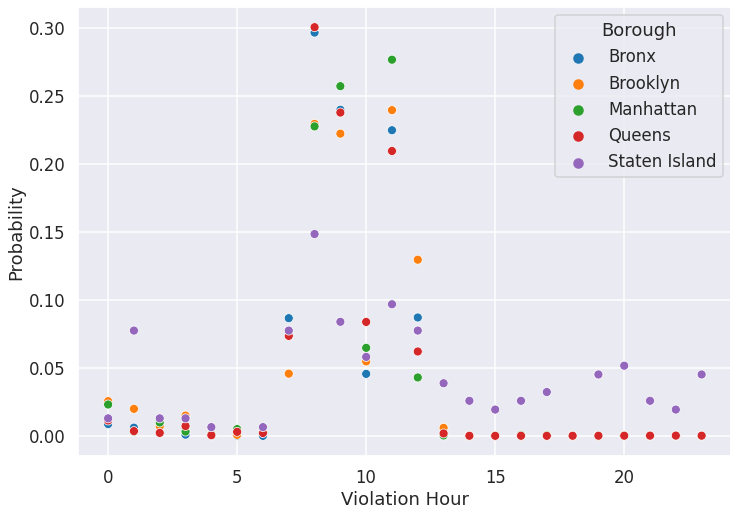

In [42]:
# Plot violation probabilities by hour and borough using
# seaborn scatter plot.

import seaborn as sns
import matplotlib.pyplot as plt

from openclean.function.eval.base import Eval

sns.set_theme()
sns.set_context("talk", font_scale=1.)

# sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

viol = df.groupby(['Violation Hour','Borough'])['Count'].sum().reset_index()
viol = stream(viol)\
    .update('Count', Eval(['Borough', 'Count'], normalize, is_unary=False))\
    .rename('Count', 'Probability')\
    .to_df()
sns.scatterplot(x='Violation Hour', y='Probability', hue='Borough', palette='tab10', data=viol, ax=ax)